## Final Project Submission

Please fill out:
* Student name: Jeff Spagnola
* Student pace: Full Time 
* Scheduled project review date/time: Monday, August 3rd, 2020 - 2:00pm
* Instructor name: James Irving
* Blog post URL:


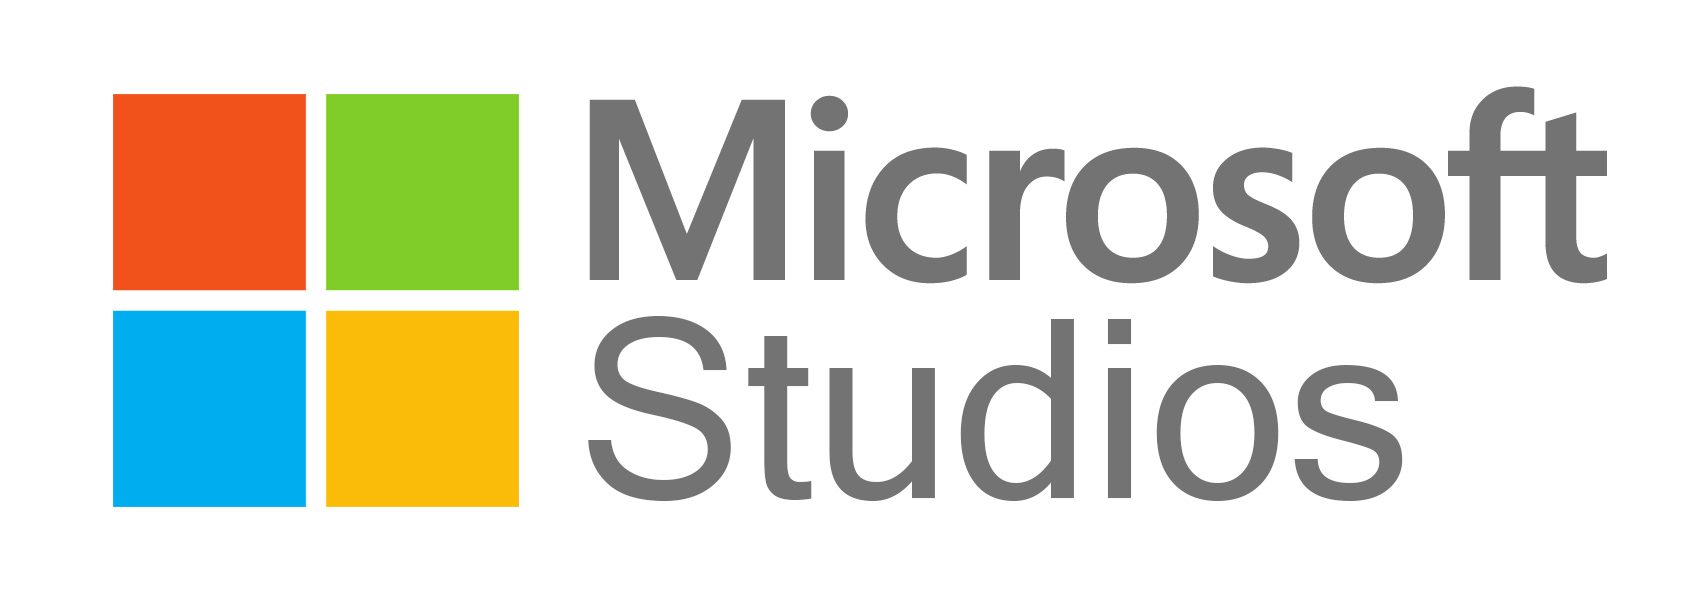

# Introduction

## Overview

Microsoft has recognized that other large tech corporations have found ample success in the film industry by producing their own original content.  The creation of the Microsoft Studios will create an entirely new revenue stream for the company as well as provide many opportunities to synergize with existing Microsoft products.  However, with a high-dollar point of entry and Microsoft's sterling reputation on the line, this can also prove to be a risky venture.  How can we minimize this risk and maximize the return on investment by using a data-driven production system?

Over the course of this notebook, we will answer the following questions:
 - Is there a correlation between a film's budget and it's performance at the box office?
 - Do films in certain genres perform better at the box office?  If so, which genres?
 - Is there a correlation between a film's MPAA rating and it's ROI?
 - Does a film's runtime have any affect on it's worldwide gross?


## Additional Notes

### Special Thanks

This analysis could not be done without the combined efforts of the P2P Study Group.  The data contained in imdb_money_ratings was scraped with 'test_requests.py' (found in the notebook) which was written by Sam Stoltenberg with the combined computing strength of the group.   

### List of Functions

In [17]:
# Gets info from the csv

def get_info (csv_name):
    print(csv_name.shape)
    print()
    print(csv_name.describe())
    print()
    print(csv_name.info())
    print()
    print(csv_name.isna().sum())


# Import and Clean Provided Datasets

In [374]:
!pip install -U plotly

     |████████████████████████████████| 12.9MB 208kB/s eta 0:00:01
  Found existing installation: plotly 4.1.1
    Uninstalling plotly-4.1.1:
      Successfully uninstalled plotly-4.1.1


In [406]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import requests
from bs4 import BeautifulSoup
import time
import plotly.express as px
import matplotlib.ticker as mtick

In [596]:
# Changes floats from scientific notation to more readable numbers. 
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set dark background for Seaborn
plt.style.use("dark_background")

### Clean IMDB Title Basics CSV - CLEANED
This CSV contains basic information pertaining to films listed on IMDB, including title, genre, year released, and runtime.  Most importantly, it contains the 'tconst' column which is a unique code used by IMDB to organize their films.  This will be useful later in joining the different data sets. 

In [77]:
# Imported the CSV file

imdb_title_basics_df = pd.read_csv('zippedData/imdb.title.basics.csv.gz', compression = 'gzip')
imdb_title_basics_df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [78]:
# Using a function to get basic data

get_info(imdb_title_basics_df)

(146144, 6)

          start_year  runtime_minutes
count  146144.000000    114405.000000
mean     2014.621798        86.187247
std         2.733583       166.360590
min      2010.000000         1.000000
25%      2012.000000        70.000000
50%      2015.000000        87.000000
75%      2017.000000        99.000000
max      2115.000000     51420.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB
None

tconst                 0
primary_title          0
original_title        21
start_year     

In [79]:
# Finding the median of runtime_minutes

imdb_title_basics_df['runtime_minutes'].median()

87.0

In [80]:
# Replacing the null values in runtime_minutes with the median. (side note...not sure why I couldn't pass in the 
# code to get the median as the argument.

imdb_title_basics_df['runtime_minutes'].fillna(87.0, inplace = True)

In [81]:
#Finding the mode of 'genres'

imdb_title_basics_df['genres'].mode()

0    Documentary
dtype: object

In [82]:
#Filling the null values with the mode.

imdb_title_basics_df['genres'].fillna('Documentary', inplace = True)
#imdb_title_basics_df.head()

In [83]:
imdb_title_basics_df.dropna(axis = 0, inplace = True)

In [84]:
#imdb_title_basics_df.head()
print(imdb_title_basics_df.shape)

(146123, 6)


In [85]:
# Getting the value counts for each column to search for weirdness.

imdb_title_basics_columns = imdb_title_basics_df.columns
for column in imdb_title_basics_columns:
    display(imdb_title_basics_df[column].value_counts())

tt6771402     1
tt5768380     1
tt1422778     1
tt2090626     1
tt7241578     1
             ..
tt6140946     1
tt1843148     1
tt2093979     1
tt2291284     1
tt10340452    1
Name: tconst, Length: 146123, dtype: int64

Home                        24
Broken                      20
The Return                  20
Alone                       16
Homecoming                  16
                            ..
Holland Road                 1
Gijs                         1
Anne Frank, Then and Now     1
Without Powder               1
Warning Label                1
Name: primary_title, Length: 136056, dtype: int64

Broken                                              19
Home                                                18
The Return                                          17
Freedom                                             13
Alone                                               13
                                                    ..
Bowie: The Man Who Changed the World                 1
Pinku no genba: Ikajima Yutaka 100-ponme no eiga     1
Ace on Fire                                          1
Yuriko no aroma                                      1
Ice                                                  1
Name: original_title, Length: 137773, dtype: int64

2017    17494
2016    17269
2018    16846
2015    16242
2014    15589
2013    14708
2012    13786
2011    12900
2010    11849
2019     8378
2020      936
2021       83
2022       32
2023        5
2024        2
2027        1
2026        1
2025        1
2115        1
Name: start_year, dtype: int64

87.0       33653
90.0        7131
80.0        3526
85.0        2915
100.0       2662
           ...  
396.0          1
382.0          1
14400.0        1
724.0          1
540.0          1
Name: runtime_minutes, Length: 367, dtype: int64

Documentary                 37574
Drama                       21486
Comedy                       9177
Horror                       4372
Comedy,Drama                 3519
                            ...  
Short,Thriller                  1
History,Musical,Romance         1
Action,Sport,Thriller           1
Comedy,Music,Mystery            1
Action,Animation,Mystery        1
Name: genres, Length: 1085, dtype: int64

### Clean IMDB Title Ratings CSV - CLEANED
This CSV contains the user rating and vote numbers for each film listed.  Like earlier, this csv includes the 'tconst' column which will be used in a later merge.  


In [86]:
# Import the CSV

imdb_title_ratings_df = pd.read_csv('zippedData/imdb.title.ratings.csv.gz', compression = 'gzip')
imdb_title_ratings_df.head()

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [87]:
# Using a function to get basic informationa bout the dataframe.

get_info(imdb_title_ratings_df)

(73856, 3)

       averagerating      numvotes
count   73856.000000  7.385600e+04
mean        6.332729  3.523662e+03
std         1.474978  3.029402e+04
min         1.000000  5.000000e+00
25%         5.500000  1.400000e+01
50%         6.500000  4.900000e+01
75%         7.400000  2.820000e+02
max        10.000000  1.841066e+06

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB
None

tconst           0
averagerating    0
numvotes         0
dtype: int64


In [88]:
# Getting an idea for the value counts to search for any weirdness.

imdb_title_ratings_columns = imdb_title_ratings_df.columns
for column in imdb_title_ratings_columns:
    display(imdb_title_ratings_df[column].value_counts())

tt1582478    1
tt1381402    1
tt3037588    1
tt8092252    1
tt1584937    1
            ..
tt5503824    1
tt1305798    1
tt2104857    1
tt2120832    1
tt4241034    1
Name: tconst, Length: 73856, dtype: int64

7.0     2262
6.6     2251
7.2     2249
6.8     2239
6.5     2221
        ... 
9.6       18
10.0      16
9.8       15
9.7       12
9.9        5
Name: averagerating, Length: 91, dtype: int64

6        2875
5        2699
7        2476
8        2167
9        1929
         ... 
18286       1
16289       1
1958        1
4007        1
4098        1
Name: numvotes, Length: 7349, dtype: int64

# Import Additional Data With Web Scraping 

## Box Office Results of Movie Franchises - FUTURE WORK

Address this in the future.  Link for scrape = https://www.the-numbers.com/movies/franchises#franchise_overview=od1

In [57]:
franchise_page = requests.get('https://www.the-numbers.com/movies/franchises') 
soup = BeautifulSoup(franchise_page.content, 'html.parser') 

In [58]:
soup.prettify

<bound method Tag.prettify of <!DOCTYPE html>

<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
<head>
<!-- Global site tag (gtag.js) - Google Analytics -->
<script async="" src="https://www.googletagmanager.com/gtag/js?id=UA-1343128-1"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-1343128-1');
</script>
<meta content='(PICS-1.1 "https://www.icra.org/ratingsv02.html" l gen true for "https://www.the-numbers.com/" r (cb 1 lz 1 nz 1 oz 1 vz 1) "https://www.rsac.org/ratingsv01.html" l gen true for "https://www.the-numbers.com/" r (n 0 s 0 v 0 l 0))' http-equiv="PICS-Label"/>
<!--<meta http-equiv="Content-Type" content="text/html; charset=ISO-8859-1" >-->
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="telephone=no" name="format-detection"/> <!-- for apple mobile -->
<meta content="521546213" property="fb:admins">

In [181]:
franchise_data = soup.findAll('table')
franchise_data


[<table class="display compact" id="franchise_overview">
 <thead><tr><th>Franchise</th><th>No. of Movies</th><th>Domestic Box Office</th><th>Infl. Adj. Dom. Box Office</th><th>Worldwide Box Office</th><th>First Year</th><th>Last Year</th><th>No. of Years</th></tr></thead>
 <tbody>
 <tr>
 <td><b><a href="/movies/franchise/Marvel-Cinematic-Universe">Marvel Cinematic Universe</a></b></td></tr></tbody></table>]

In [60]:
from html.parser import HTMLParser

In [61]:
edited_franchise = franchise_data.text
edited_franchise

AttributeError: ResultSet object has no attribute 'text'. You're probably treating a list of items like a single item. Did you call find_all() when you meant to call find()?

## IMDB Scraped with Group

This scrape was a group effort with the core P2P study group team.  Each person took on a section of IMDB 'tconst' codes to scrape useful monetary and rating data.  The combined computing power allowed us to cut scrape time from 11 days down to around 9 hours.  To see the code for the scrape, please refer to 'test_requests.py'.

In [97]:
#Import the CSV

imdb_money_ratings = pd.read_csv('budget_ratings.csv')
imdb_money_ratings.head()

,Unnamed: 0,tconst,budget,gross,ww_gross,rating
0,0,tt2200832,NaN,NaN,NaN,NotRated
1,1,tt2200860,NaN,NaN,1924766.0,NaN
2,2,tt2200908,NaN,NaN,105367.0,NaN
3,3,tt2200926,NaN,NaN,5784.0,NaN
4,4,tt2200955,NaN,NaN,NaN,Comedy


In [98]:
# Get info on the csv using a function.

get_info(imdb_money_ratings)

(52943, 6)

         Unnamed: 0        budget         gross      ww_gross
count  52943.000000  1.939600e+04  6.233000e+03  2.092100e+04
mean   26471.000000  6.315791e+06  1.748960e+07  1.632157e+07
std    15283.471988  3.122318e+07  5.519507e+07  8.563210e+07
min        0.000000  0.000000e+00  7.200000e+01  0.000000e+00
25%    13235.500000  5.000000e+03  2.409400e+04  3.482900e+04
50%    26471.000000  1.865000e+05  1.752320e+05  3.274530e+05
75%    39706.500000  1.000000e+06  4.033574e+06  2.935188e+06
max    52942.000000  9.000000e+08  9.366622e+08  2.797801e+09

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52943 entries, 0 to 52942
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  52943 non-null  int64  
 1   tconst      52943 non-null  object 
 2   budget      19396 non-null  float64
 3   gross       6233 non-null   float64
 4   ww_gross    20921 non-null  float64
 5   rating      35743 non-null  o

In [99]:
# Check the unique values within the ratings.  Uh oh...

imdb_money_ratings['rating'].unique()

array(['NotRated', nan, 'Comedy', 'Thriller', 'Documentary', 'R', 'TV-PG',
       'Family', 'PG-13', 'Drama,', 'TV-G', 'PG', 'Family,', 'Sci-Fi',
       'Comedy,', 'TV-MA', 'Biography,', 'Horror', 'G', 'Unrated',
       'Drama', 'Action', 'Romance', 'TV-14', 'Romance,', 'Sport',
       'Biography', 'Horror,', 'Action,', '27January2012(USA)',
       'TVMovie31October2010', 'Mystery', 'Crime,', 'Reality-TV',
       'History', 'Fantasy', 'TV-Y7', 'Animation,', '5May2012(USA)',
       'Music', 'Documentary,', 'Adventure,', 'TV-Y', 'Crime', 'NC-17',
       'Western', 'TV-Y7-FV', '2April2016(Japan)', 'Approved',
       '22March2012(Spain)', '19July2012(Portugal)', 'Adventure',
       'Musical', 'M', 'TVMovie21April2011', '12September2012(Poland)',
       'Animation', 'History,', 'TVMovie20April2012',
       '25April2014(Spain)', '5July2013(France)', 'Adult', 'Fantasy,',
       '25February2013(BurkinaFaso)', '7October2012(USA)', 'X',
       '23May2013(Argentina)', '12June2014(Italy)', 'War',


In [101]:
# Removed the junk data and replaced with NaN's.

ratings = ['M/PG', 'MA-17', 'X', 'M', 'C', 'T', 'E', 'E10+', 'TV-Y7-FV', 'NC-17', 'TV-Y',
           'TV-Y7', 'TV-14', 'G', 'TV-MA', 'PG', 'TV-G', 'PG-13', 'TV-PG', 'R']
for i in imdb_money_ratings['rating']:
    if i not in ratings:
        imdb_money_ratings['rating'].replace(i, np.nan, inplace=True)
    

In [102]:
imdb_money_ratings['rating'].unique()

array([nan, 'R', 'TV-PG', 'PG-13', 'TV-G', 'PG', 'TV-MA', 'G', 'TV-14',
       'TV-Y7', 'TV-Y', 'NC-17', 'TV-Y7-FV', 'M', 'X', 'E10+', 'E', 'C',
       'T', 'M/PG', 'MA-17'], dtype=object)

In [103]:
imdb_money_ratings.head()

,Unnamed: 0,tconst,budget,gross,ww_gross,rating
0,0,tt2200832,NaN,NaN,NaN,NaN
1,1,tt2200860,NaN,NaN,1924766.0,NaN
2,2,tt2200908,NaN,NaN,105367.0,NaN
3,3,tt2200926,NaN,NaN,5784.0,NaN
4,4,tt2200955,NaN,NaN,NaN,NaN


<h5> NOTE: </h5>
Tons of missing data in here.  Decided to whittle down from 52k listings to a smaller set that will represent ACCURATELY reported data from reputable studios.  Ran a check to make sure that this did not eliminate data on mainstream content (wide releases, blockbuster movies, noteworthy films, etc.)


In [104]:
#Dropping columns with missing information

imdb_money_ratings.dropna(axis = 0, inplace=True)
imdb_money_ratings.head()

,Unnamed: 0,tconst,budget,gross,ww_gross,rating
48,48,tt2203939,40000000.0,83911193.0,196710396.0,PG-13
67,67,tt2205401,5000000.0,17390770.0,17534314.0,R
73,73,tt2205591,100000.0,71737.0,71737.0,PG
92,92,tt2207006,10000000.0,110904.0,110904.0,PG-13
121,121,tt2209418,3000000.0,8114627.0,20994648.0,R


In [105]:
imdb_money_ratings.shape

(2225, 6)

In [545]:
imdb_money_ratings.head(10)

,Unnamed: 0,tconst,budget,gross,ww_gross,rating
48,48,tt2203939,40000000.00,83911193.00,196710396.00,PG-13
67,67,tt2205401,5000000.00,17390770.00,17534314.00,R
73,73,tt2205591,100000.00,71737.00,71737.00,PG
92,92,tt2207006,10000000.00,110904.00,110904.00,PG-13
121,121,tt2209418,3000000.00,8114627.00,20994648.00,R
129,129,tt2209764,100000000.00,23022309.00,103039258.00,PG-13
209,209,tt2215077,270000000.00,54529.00,306393.00,R
223,223,tt2215285,20000000.00,65653242.00,66899242.00,PG-13
241,241,tt2215719,12000000.00,25326071.00,32726956.00,PG
249,249,tt2216240,500000.00,414437.00,2688444.00,R


# Join Data into Single Dataframe

In this section, I've first merged the imdb_title_basics_df & imdb_title_ratings_df.  Then, merged this new dataframe with the additional data scraped from IMDB.  This left me with one extremely useful dataframe representing 2225 films. 

## Merge Dataframes

In [106]:
#Merging the imdb_title_basics & imddb_title_ratings dataframes.

imdb_df = pd.merge(left=imdb_title_basics_df, right=imdb_title_ratings_df, how='left', left_on='tconst', right_on='tconst')
imdb_df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,87.0,"Comedy,Drama",6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0


In [107]:
#Merging the resulting dataframe with the IMDB data that was scraped.  

imdb_full_df = pd.merge(left=imdb_money_ratings, right=imdb_df, how='left', left_on='tconst', right_on='tconst')
imdb_full_df.head()

,Unnamed: 0,tconst,budget,gross,ww_gross,rating,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,48,tt2203939,40000000.0,83911193.0,196710396.0,PG-13,The Other Woman,The Other Woman,2014.0,109.0,"Comedy,Romance",6.0,122889.0
1,67,tt2205401,5000000.0,17390770.0,17534314.0,R,Addicted,Addicted,2014.0,106.0,"Drama,Thriller",5.2,7640.0
2,73,tt2205591,100000.0,71737.0,71737.0,PG,Runaway Slave,Runaway Slave,2012.0,108.0,"Documentary,History",6.7,269.0
3,92,tt2207006,10000000.0,110904.0,110904.0,PG-13,The Obama Effect,The Obama Effect,2012.0,85.0,"Comedy,Drama",2.0,378.0
4,121,tt2209418,3000000.0,8114627.0,20994648.0,R,Before Midnight,Before Midnight,2013.0,109.0,"Drama,Romance",7.9,123107.0


In [108]:
# Dropped the old index column

imdb_full_df.drop(labels = 'Unnamed: 0', axis = 1, inplace = True)
imdb_full_df.head()

,tconst,budget,gross,ww_gross,rating,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt2203939,40000000.0,83911193.0,196710396.0,PG-13,The Other Woman,The Other Woman,2014.0,109.0,"Comedy,Romance",6.0,122889.0
1,tt2205401,5000000.0,17390770.0,17534314.0,R,Addicted,Addicted,2014.0,106.0,"Drama,Thriller",5.2,7640.0
2,tt2205591,100000.0,71737.0,71737.0,PG,Runaway Slave,Runaway Slave,2012.0,108.0,"Documentary,History",6.7,269.0
3,tt2207006,10000000.0,110904.0,110904.0,PG-13,The Obama Effect,The Obama Effect,2012.0,85.0,"Comedy,Drama",2.0,378.0
4,tt2209418,3000000.0,8114627.0,20994648.0,R,Before Midnight,Before Midnight,2013.0,109.0,"Drama,Romance",7.9,123107.0


In [109]:
#Sorted the dataframe in descending order by worldwide gross.  

imdb_full_df.sort_values('ww_gross', ascending = False, inplace = True)

In [548]:
# Dropped the original title column.  Only want the most known titles. 

#imdb_full_df.drop(labels = 'original_title', axis = 1, inplace = True)
#print(imdb_full_df.shape)
#imdb_full_df.head()

## Analyze, Clean, and Alter Main Dataframe

In [212]:
# Adding a 'net revenue' column by subtracting the budget from the worldwide gross.  

imdb_full_df['Net_Revenue'] = imdb_full_df['ww_gross'] - imdb_full_df['budget']
imdb_full_df.head()

,tconst,budget,gross,ww_gross,rating,primary_title,start_year,runtime_minutes,averagerating,numvotes,Net_Revenue,genre_list
780,tt4154796,356000000.00,858373000.00,2797800564.00,PG-13,Avengers: Endgame,2019.00,181.00,8.80,441135.00,2441800564.00,"[Action, Adventure, Sci-Fi]"
176,tt2488496,245000000.00,936662225.00,2068223624.00,PG-13,Star Wars: Episode VII - The Force Awakens,2015.00,136.00,8.00,784780.00,1823223624.00,"[Action, Adventure, Fantasy]"
779,tt4154756,321000000.00,678815482.00,2048359754.00,PG-13,Avengers: Infinity War,2018.00,149.00,8.50,670926.00,1727359754.00,"[Action, Adventure, Sci-Fi]"
1164,tt0369610,150000000.00,652270625.00,1670400637.00,PG-13,Jurassic World,2015.00,124.00,7.00,539338.00,1520400637.00,"[Action, Adventure, Sci-Fi]"
2136,tt6105098,260000000.00,543638043.00,1656943394.00,PG,The Lion King,2019.00,87.00,nan,nan,1396943394.00,"[Adventure, Animation, Drama]"


In [214]:
# Dealing with the genres column being a single string listing multiple genres.  


In [113]:
sum(imdb_full_df['genres'].isna())  #ran into a snag with some NaN's

5

In [114]:
imdb_full_df['genres'].mode()

0    Drama
dtype: object

In [115]:
imdb_full_df['genres'].fillna('Drama', inplace = True) #Fixed it

In [116]:
# Splitting the genre column into a list of separate strings

imdb_full_df['genre_list'] = imdb_full_df['genres'].apply(lambda x: x.split(','))
imdb_full_df['genre_list']


780       [Action, Adventure, Sci-Fi]
176      [Action, Adventure, Fantasy]
779       [Action, Adventure, Sci-Fi]
1164      [Action, Adventure, Sci-Fi]
2136    [Adventure, Animation, Drama]
                    ...              
247            [Comedy, Crime, Drama]
965                   [Comedy, Drama]
122                    [Crime, Drama]
1219         [Comedy, Drama, Romance]
712                       [Animation]
Name: genre_list, Length: 2225, dtype: object

In [117]:
# Removing pre-existing genres column. 

imdb_full_df.drop('genres', axis = 1, inplace = True)
imdb_full_df.head()

,tconst,budget,gross,ww_gross,rating,primary_title,start_year,runtime_minutes,averagerating,numvotes,Net_Revenue,genre_list
780,tt4154796,356000000.0,858373000.0,2.797801e+09,PG-13,Avengers: Endgame,2019.0,181.0,8.8,441135.0,2.441801e+09,"[Action, Adventure, Sci-Fi]"
176,tt2488496,245000000.0,936662225.0,2.068224e+09,PG-13,Star Wars: Episode VII - The Force Awakens,2015.0,136.0,8.0,784780.0,1.823224e+09,"[Action, Adventure, Fantasy]"
779,tt4154756,321000000.0,678815482.0,2.048360e+09,PG-13,Avengers: Infinity War,2018.0,149.0,8.5,670926.0,1.727360e+09,"[Action, Adventure, Sci-Fi]"
1164,tt0369610,150000000.0,652270625.0,1.670401e+09,PG-13,Jurassic World,2015.0,124.0,7.0,539338.0,1.520401e+09,"[Action, Adventure, Sci-Fi]"
2136,tt6105098,260000000.0,543638043.0,1.656943e+09,PG,The Lion King,2019.0,87.0,NaN,NaN,1.396943e+09,"[Adventure, Animation, Drama]"


# Analysis

## Q1. Is there a correlation between a film's budget and it's performance at the box office?

In [118]:
imdb_full_df.head()

,tconst,budget,gross,ww_gross,rating,primary_title,start_year,runtime_minutes,averagerating,numvotes,Net_Revenue,genre_list
780,tt4154796,356000000.0,858373000.0,2.797801e+09,PG-13,Avengers: Endgame,2019.0,181.0,8.8,441135.0,2.441801e+09,"[Action, Adventure, Sci-Fi]"
176,tt2488496,245000000.0,936662225.0,2.068224e+09,PG-13,Star Wars: Episode VII - The Force Awakens,2015.0,136.0,8.0,784780.0,1.823224e+09,"[Action, Adventure, Fantasy]"
779,tt4154756,321000000.0,678815482.0,2.048360e+09,PG-13,Avengers: Infinity War,2018.0,149.0,8.5,670926.0,1.727360e+09,"[Action, Adventure, Sci-Fi]"
1164,tt0369610,150000000.0,652270625.0,1.670401e+09,PG-13,Jurassic World,2015.0,124.0,7.0,539338.0,1.520401e+09,"[Action, Adventure, Sci-Fi]"
2136,tt6105098,260000000.0,543638043.0,1.656943e+09,PG,The Lion King,2019.0,87.0,NaN,NaN,1.396943e+09,"[Adventure, Animation, Drama]"


In [222]:
# Creating a smaller dataframe with title, budget, and net revenue.

budget_roi_df = imdb_full_df.loc[:, ['primary_title', 'budget', 'Net_Revenue']]
budget_roi_df.head()
                                 

,primary_title,budget,Net_Revenue
780,Avengers: Endgame,356000000.00,2441800564.00
176,Star Wars: Episode VII - The Force Awakens,245000000.00,1823223624.00
779,Avengers: Infinity War,321000000.00,1727359754.00
1164,Jurassic World,150000000.00,1520400637.00
2136,The Lion King,260000000.00,1396943394.00


In [223]:
budget_roi_df.describe()

,budget,Net_Revenue
count,2225.00,2225.00
mean,37415217.63,85327318.16
std,51450407.15,194055588.31
min,0.00,-297460960.00
25%,5000000.00,-985307.00
50%,18000000.00,15544024.00
75%,43000000.00,80102725.00
max,356000000.00,2441800564.00


In [121]:
#Checking the correlation between budget and revenue. 

budget_roi_df.corr()

,budget,Net_Revenue
budget,1.000000,0.669251
Net_Revenue,0.669251,1.000000


In [234]:
budget_roi_df

,primary_title,budget,Net_Revenue
780,Avengers: Endgame,356000000.00,2441800564.00
176,Star Wars: Episode VII - The Force Awakens,245000000.00,1823223624.00
779,Avengers: Infinity War,321000000.00,1727359754.00
1164,Jurassic World,150000000.00,1520400637.00
2136,The Lion King,260000000.00,1396943394.00
...,...,...,...
247,L.A. Slasher,10000.00,-7579.00
965,Best Man Down,1500000.00,-1498062.00
122,Rhymes for Young Ghouls,500000.00,-498471.00
1219,Syrup,2500000.00,-2499337.00


In [382]:
# Dropping 5 films with NaN's for title. 

budget_roi_df = budget_roi_df.dropna()

In [609]:
budget_roi_df['budget'].describe()

count        2220.00
mean     37476033.44
std      51485746.55
min             0.00
25%       5000000.00
50%      18000000.00
75%      43250000.00
max     356000000.00
Name: budget, dtype: float64

### Fig. 1 - Budget vs. Revenue
In the figure below, the goal is to see if there exists a "sweet spot" in terms of a production budget where we can maximize the rate of return.  The top 250 highest grossing films are represented and the larger the plot point, the higher the net profit.  As we can see, outside of a handful of "home runs", the area of the most consistent rate of return is where <b> the production budget falls between 100 and 200 million dollars. </b>

In [600]:
#Created a scatter plot showing the relationhip between budget and revenue across the top 250 highest grossing films.

px.scatter(budget_roi_df.head(250), x="budget", y="Net_Revenue", title = 'Budget vs. Revenue', 
           labels = {'Net_Revenue': 'Net Profit', 'budget': 'Production Budget', 'primary_title': 'Top 250 Highest Grossing Films'}, 
           color = 'primary_title', size = 'Net_Revenue', template = 'plotly_dark')


### Fig 2. - Production Budget vs. Sum of Net Revenues
After figuring out that the budget "sweet spot" is between 100 and 200 million dollars, I wanted to see if I could narrow that range down a bit and figure out a more exact number.  Using the same scope of the top 250 highest grossing films, we can now see that <b>the budget range that has earned the most money in the last 10 years is $160-170 million. </b>

In [599]:
# I want to get a little tighter of a scope as far as optimal budget.

px.histogram(data_frame = budget_roi_df.head(250), x ='budget', y = 'Net_Revenue', color = 'primary_title', 
             title = 'Production Budget vs. Sum of Net Revenues', template = 'plotly_dark',
             labels = {'budget': 'Production Budget', 'Net_Revenue': 'Net Revenues', 'primary_title': 'Top 250 Highest Grossing Films'})

## Q2. Do movies in certain genres perform better at the box office?

In [196]:
# Creating a smaller dataframe to work with.  Using just title, genre, and net revenue. 

genre_revenue_df = imdb_full_df.loc[:, ['primary_title', 'genre_list', 'Net_Revenue']]
genre_revenue_df.head()

,primary_title,genre_list,Net_Revenue
780,Avengers: Endgame,"[Action, Adventure, Sci-Fi]",2441800564.00
176,Star Wars: Episode VII - The Force Awakens,"[Action, Adventure, Fantasy]",1823223624.00
779,Avengers: Infinity War,"[Action, Adventure, Sci-Fi]",1727359754.00
1164,Jurassic World,"[Action, Adventure, Sci-Fi]",1520400637.00
2136,The Lion King,"[Adventure, Animation, Drama]",1396943394.00


In [197]:
# Giving each listed genre it's own row, as many films have multiple genres. 

genre_revenue_df = genre_revenue_df.explode('genre_list')
genre_revenue_df

,primary_title,genre_list,Net_Revenue
780,Avengers: Endgame,Action,2441800564.00
780,Avengers: Endgame,Adventure,2441800564.00
780,Avengers: Endgame,Sci-Fi,2441800564.00
176,Star Wars: Episode VII - The Force Awakens,Action,1823223624.00
176,Star Wars: Episode VII - The Force Awakens,Adventure,1823223624.00
...,...,...,...
122,Rhymes for Young Ghouls,Drama,-498471.00
1219,Syrup,Comedy,-2499337.00
1219,Syrup,Drama,-2499337.00
1219,Syrup,Romance,-2499337.00


In [198]:
genre_revenue_df.nunique()

primary_title    2213
genre_list         22
Net_Revenue      2225
dtype: int64

In [413]:
genre_revenue_df.isna().sum()

genre_list     0
Net_Revenue    0
dtype: int64

In [199]:
# Filtering the info further by dropping the title, giving me just the genre and how much money earned. 

genre_revenue_df.drop('primary_title', axis = 1, inplace = True)
genre_revenue_df.head()

,genre_list,Net_Revenue
780,Action,2441800564.00
780,Adventure,2441800564.00
780,Sci-Fi,2441800564.00
176,Action,1823223624.00
176,Adventure,1823223624.00


In [420]:
# Sorting by net revenue in descending order.

genre_revenue_df = genre_revenue_df.sort_values('Net_Revenue', ascending = False) 
genre_revenue_df.head()

,genre_list,Net_Revenue
780,Action,2441800564.00
780,Adventure,2441800564.00
780,Sci-Fi,2441800564.00
176,Action,1823223624.00
176,Fantasy,1823223624.00


In [127]:
# Creating one last dataframe that combines all films of a specific genre and adds their net revenue.

final_genre_revenue_df = genre_revenue_df.groupby('genre_list')['Net_Revenue'].sum()

In [412]:
final_genre_revenue_df

,genre_list,Net_Revenue
1,Adventure,113099831032.00
0,Action,92826638300.00
4,Comedy,63905673494.00
7,Drama,47718210113.00
17,Sci-Fi,38685229726.00
2,Animation,35708851452.00
19,Thriller,30313136806.00
9,Fantasy,29172257317.00
5,Crime,15669758854.00
8,Family,14713346815.00


In [159]:
#change from groupby back into a dataframe
#final_genre_revenue_df = final_genre_revenue_df.to_frame(name = 'Net_Revenue').reset_index()

In [206]:
final_genre_revenue_df = final_genre_revenue_df.sort_values('Net_Revenue', ascending = False) 

In [549]:
#final_genre_revenue_df

#### Fig. 3 - Net Profit by Genre
The figure below represents the total net revenue for each major genre over the past 10 years.  It is extremely apparent that <b>the Adventure and Action genres make up an overwhelmingly large portion of the total profits of the entire film industry.</b>  

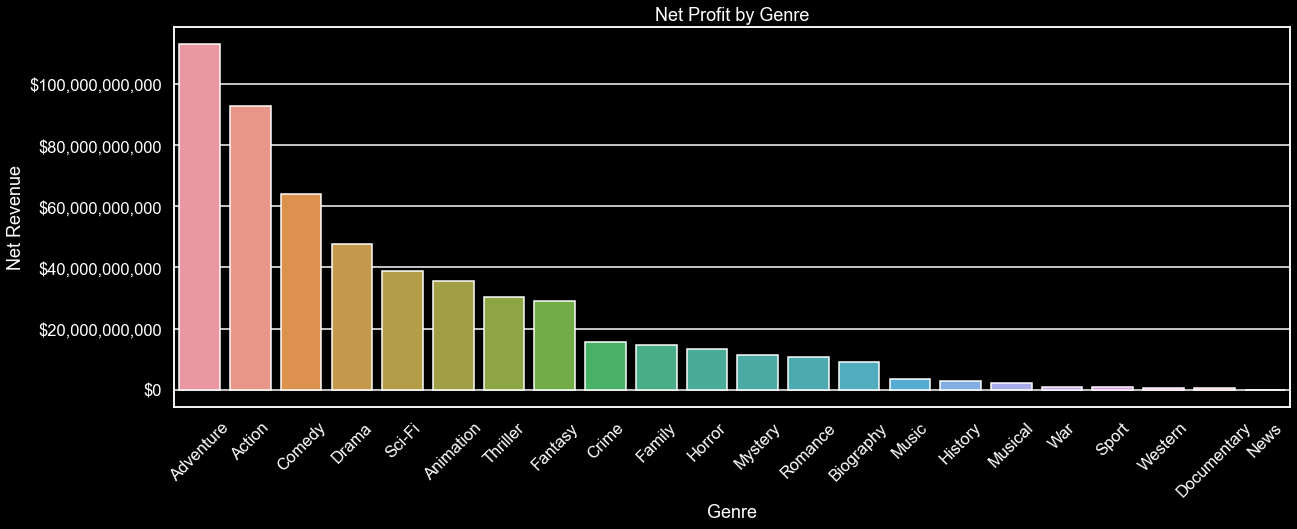

In [601]:
#Created a plot representing the net profit by genre. 

plt.figure(figsize = (20,7))
#sns.set_context("talk")
#with sns.plotting_context(font_scale = 1):
ax = sns.barplot(x = 'genre_list', y = 'Net_Revenue', data = final_genre_revenue_df, ci = 68)
ax.set_title('Net Profit by Genre')
ax.set_xlabel('Genre')
ax.set_ylabel('Net Revenue')


fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=45);

After reviewing the above plot, I was curious about whether the top few highest grossing films of all time may have been tipping the scale in a certain direction.  It's entirely possible that a particular genre may perform better more regularly but massive films are skewing that figure.  Let's find out.  

In [295]:
# Creating another dataframe with title, genre, and revenue.

title_genre_df = imdb_full_df.loc[:, ['primary_title', 'genre_list', 'Net_Revenue']]
title_genre_df.head()

,primary_title,genre_list,Net_Revenue
780,Avengers: Endgame,"[Action, Adventure, Sci-Fi]",2441800564.00
176,Star Wars: Episode VII - The Force Awakens,"[Action, Adventure, Fantasy]",1823223624.00
779,Avengers: Infinity War,"[Action, Adventure, Sci-Fi]",1727359754.00
1164,Jurassic World,"[Action, Adventure, Sci-Fi]",1520400637.00
2136,The Lion King,"[Adventure, Animation, Drama]",1396943394.00


In [296]:
title_genre_df = title_genre_df.dropna()  #dropped 5

In [297]:
title_genre_df.isna().sum()

primary_title    0
genre_list       0
Net_Revenue      0
dtype: int64

In [298]:
# 'Exploded' out the genre list again. 

title_genre_df = title_genre_df.explode('genre_list')

#### Fig. 4 - Genre Frequency in Top 250 Highest Grossing Films
The figure below represents the top 250 highest grossing films of the past 10 years and the frequency that each genre appears within that list of 250.  As you can see, <b>an overwhelming majority of the top grossing movies are in the Action and Adventure genres.</b>  

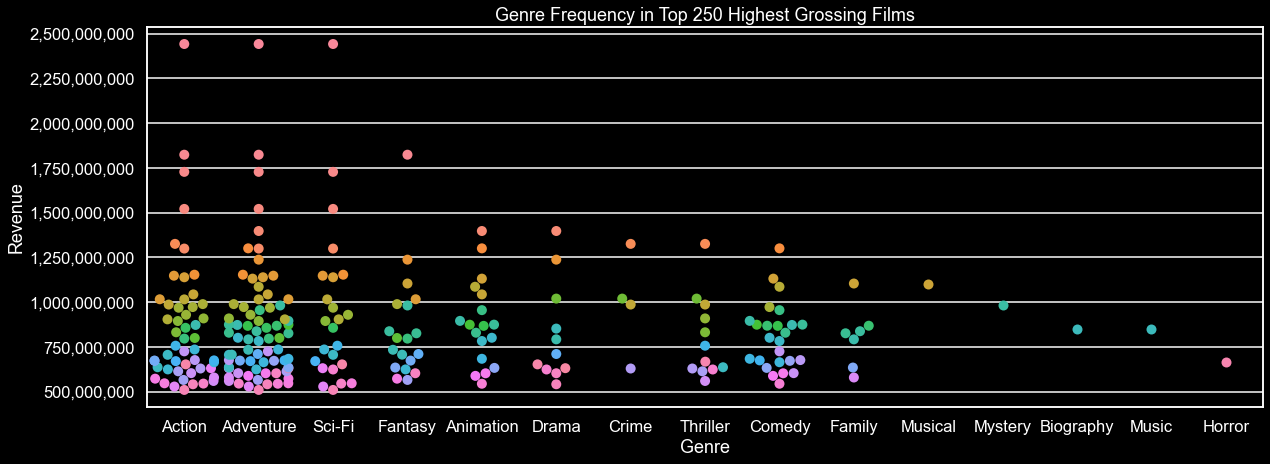

In [602]:
# Created a plot showing the genre frequency of the top 250 highest grossing films. 

plt.figure(figsize = (20,7))
sns.set_context("talk")
with sns.plotting_context(font_scale = 1.5):
    g = sns.swarmplot(x="genre_list", y="Net_Revenue", hue="primary_title", size = 10, data=title_genre_df.head(250))
    g.legend_.remove()
    g.set_title('Genre Frequency in Top 250 Highest Grossing Films')
    g.set_xlabel('Genre')
    g.set_ylabel('Revenue')
    g.set_yticklabels(['{:,}'.format(int(x)) for x in g.get_yticks().tolist()])

## Q3. What is the relationship between a film's MPAA rating and it's performance at the box office?

In [307]:
# Created smaller rating dataframe.

rating_revenue_df = imdb_full_df.loc[:, ['primary_title', 'rating', 'Net_Revenue']]
rating_revenue_df.head()

,primary_title,rating,Net_Revenue
780,Avengers: Endgame,PG-13,2441800564.00
176,Star Wars: Episode VII - The Force Awakens,PG-13,1823223624.00
779,Avengers: Infinity War,PG-13,1727359754.00
1164,Jurassic World,PG-13,1520400637.00
2136,The Lion King,PG,1396943394.00


In [308]:
# Checked the value counts.  Ew there's still TV ratings.

rating_revenue_df['rating'].value_counts()

R        1026
PG-13     814
PG        321
G          26
TV-MA      18
TV-14      15
TV-PG       2
NC-17       2
TV-G        1
Name: rating, dtype: int64

In [313]:
# Removing irrelevant ratings

ratings_list = ['R', 'PG-13', 'PG', 'G', 'NC-17']
for i in rating_revenue_df['rating']:
    if i not in ratings_list:
        rating_revenue_df['rating'].replace(i, np.nan, inplace=True)
    
rating_revenue_df['rating'].value_counts()

R        1026
PG-13     814
PG        321
G          26
NC-17       2
Name: rating, dtype: int64

<h5> Note: </h5>
While this seems weird to keep movies with TV ratings, each of those listings does have a box office gross.  Upon further research, I learned that movies produced for television can open theatrically in some cases.  However, for the purposes of this analysis, I want to make the assumption that Microsoft will not be producing films for television.  For more information, <a href="https://help.imdb.com/article/imdb/discover-watch/how-do-you-decide-if-a-title-is-a-film-a-tv-movie-or-a-miniseries/GKUQEMEFSM54T2KT?ref_=helpart_nav_21#"> click here.</a> 


In [550]:
#Getting an overview of info using the function...again.

get_info(rating_revenue_df)

(2225, 2)

        Net_Revenue
count       2225.00
mean    85327318.16
std    194055588.31
min   -297460960.00
25%      -985307.00
50%     15544024.00
75%     80102725.00
max   2441800564.00

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 780 to 712
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rating       2225 non-null   object 
 1   Net_Revenue  2225 non-null   float64
dtypes: float64(1), object(1)
memory usage: 132.1+ KB
None

rating         0
Net_Revenue    0
dtype: int64


In [315]:
# Getting the mode of rating_revenue_df.

rating_revenue_df['rating'].mode()


0    R
dtype: object

In [316]:
# Filling the nan's with the mode.

rating_revenue_df['rating'].fillna('R', inplace = True)

In [317]:
# Dropping the titles from the dataframe. 

rating_revenue_df.drop('primary_title', axis = 1, inplace = True)

In [318]:
rating_revenue_df.head()

,rating,Net_Revenue
780,PG-13,2441800564.00
176,PG-13,1823223624.00
779,PG-13,1727359754.00
1164,PG-13,1520400637.00
2136,PG,1396943394.00


In [319]:
# Grouping the each instance of the rating into a single value and adding the net revenues. 
# Then turning it back from a series to a dataframe. 

final_rating_revenue_df = rating_revenue_df.groupby('rating')['Net_Revenue'].sum()
final_rating_revenue_df.to_frame(name = 'Net_Revenue').reset_index()



,rating,Net_Revenue
0,G,4523054422.00
1,NC-17,32089602.00
2,PG,45368046143.00
3,PG-13,99895449569.00
4,R,40034643165.00


In [320]:
type(final_rating_revenue_df)

pandas.core.series.Series

In [321]:
type(final_genre_revenue_df)

pandas.core.frame.DataFrame

In [322]:
final_rating_revenue_df.to_frame()

,Net_Revenue
rating,
G,4523054422.00
NC-17,32089602.00
PG,45368046143.00
PG-13,99895449569.00
R,40034643165.00


In [323]:
final_rating_revenue_df

rating
G        4523054422.00
NC-17      32089602.00
PG      45368046143.00
PG-13   99895449569.00
R       40034643165.00
Name: Net_Revenue, dtype: float64

In [324]:
# Took a second, but figured out how to get it to be a dataframe. 

final_rating_revenue_df = final_rating_revenue_df.to_frame(name = 'Net_Revenue').reset_index()
type(final_rating_revenue_df)

pandas.core.frame.DataFrame

In [325]:
# Sorting the dataframe by Net Revenue

final_rating_revenue_df = final_rating_revenue_df.sort_values('Net_Revenue', ascending = False) 

In [326]:
final_rating_revenue_df

,rating,Net_Revenue
3,PG-13,99895449569.00
2,PG,45368046143.00
4,R,40034643165.00
0,G,4523054422.00
1,NC-17,32089602.00


In [588]:
# Trying a few different plots
#px.box(data_frame = rating_revenue_df, x = 'rating', y = 'Net_Revenue')

#### Fig. 5 - Net Profit by Rating
The figure below represents the total net revenue of movies with particular MPAA ratings over the last 10 years.  <b> Films that are rated PG-13 make up an overwhelmingly large portion of the total profits of the entire film industry.</b>  

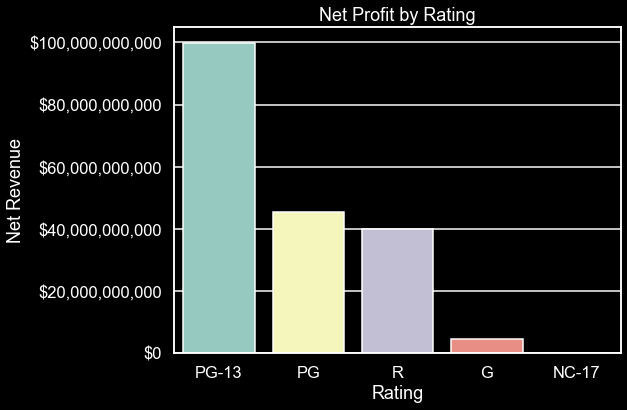

In [610]:
#Plotting out this information on a bar plot. 

plt.figure(figsize = (8,6))
ax = sns.barplot(x = 'rating', y = 'Net_Revenue', data = final_rating_revenue_df, ci = 68)
ax.set_title('Net Profit by Rating')
ax.set_xlabel('Rating')
ax.set_ylabel('Net Revenue');

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#### Fig. 6 - Rating Frequency in Top 250 Highest Grossing Films
The figure below shows the frequency of each MPAA rating within the top 250 highest grossing films over the last 10 years.  <b> PG-13 rated movies do, indeed, have the highest frequency.  </b>  

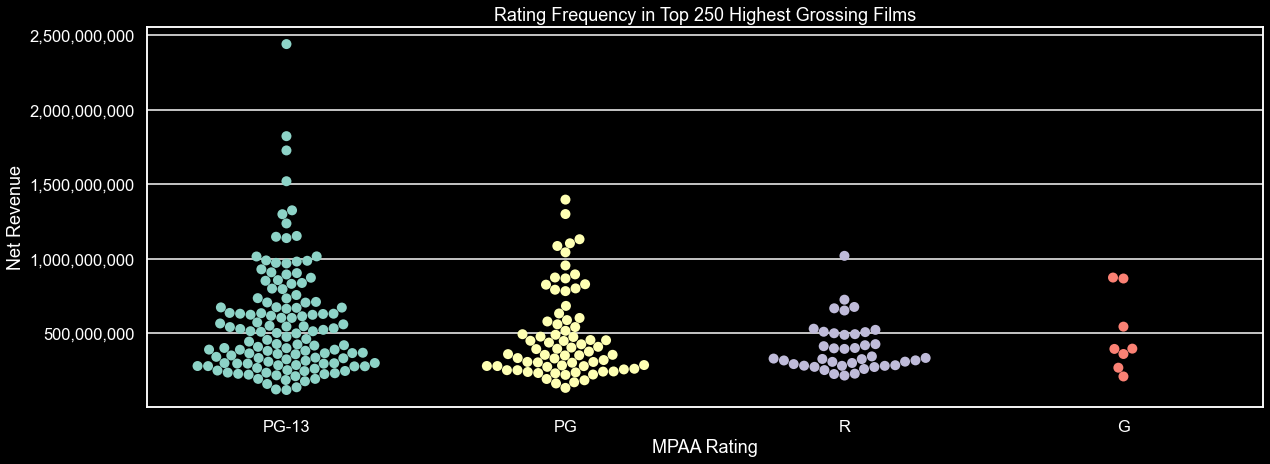

In [597]:
plt.figure(figsize = (20,7))
sns.set_context("talk")
with sns.plotting_context(font_scale = 1.5):
    g = sns.swarmplot(x="rating", y="Net_Revenue", size = 10, data=rating_revenue_df.head(250))
    g.set_title('Rating Frequency in Top 250 Highest Grossing Films')
    g.set_xlabel('MPAA Rating')
    g.set_ylabel('Net Revenue')
    g.set_yticklabels(['{:,}'.format(int(x)) for x in g.get_yticks().tolist()]);

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

## Q4. Does the length of a film affect the worldwide gross?

In [257]:
imdb_full_df.head()

,tconst,budget,gross,ww_gross,rating,primary_title,start_year,runtime_minutes,averagerating,numvotes,Net_Revenue,genre_list
780,tt4154796,356000000.00,858373000.00,2797800564.00,PG-13,Avengers: Endgame,2019.00,181.00,8.80,441135.00,2441800564.00,"[Action, Adventure, Sci-Fi]"
176,tt2488496,245000000.00,936662225.00,2068223624.00,PG-13,Star Wars: Episode VII - The Force Awakens,2015.00,136.00,8.00,784780.00,1823223624.00,"[Action, Adventure, Fantasy]"
779,tt4154756,321000000.00,678815482.00,2048359754.00,PG-13,Avengers: Infinity War,2018.00,149.00,8.50,670926.00,1727359754.00,"[Action, Adventure, Sci-Fi]"
1164,tt0369610,150000000.00,652270625.00,1670400637.00,PG-13,Jurassic World,2015.00,124.00,7.00,539338.00,1520400637.00,"[Action, Adventure, Sci-Fi]"
2136,tt6105098,260000000.00,543638043.00,1656943394.00,PG,The Lion King,2019.00,87.00,nan,nan,1396943394.00,"[Adventure, Animation, Drama]"


In [260]:
#Creating a separate dataframe with specific columns. 

runtime_gross_df = imdb_full_df.loc[:, ['primary_title', 'runtime_minutes', 'ww_gross']]
runtime_gross_df.head()

,primary_title,runtime_minutes,ww_gross
780,Avengers: Endgame,181.00,2797800564.00
176,Star Wars: Episode VII - The Force Awakens,136.00,2068223624.00
779,Avengers: Infinity War,149.00,2048359754.00
1164,Jurassic World,124.00,1670400637.00
2136,The Lion King,87.00,1656943394.00


In [267]:
#Checking for nan's

runtime_gross_df.isna().sum()

primary_title      0
runtime_minutes    0
ww_gross           0
dtype: int64

In [265]:
# Dropping a few without a title. 
runtime_gross_df = runtime_gross_df.dropna()


In [469]:
# Sorting the films by runtime 

runtime_gross_df = runtime_gross_df.sort_values('ww_gross', ascending = False) 
runtime_gross_df.head()

,primary_title,runtime_minutes,ww_gross
780,Avengers: Endgame,181.00,2797800564.00
176,Star Wars: Episode VII - The Force Awakens,136.00,2068223624.00
779,Avengers: Infinity War,149.00,2048359754.00
1164,Jurassic World,124.00,1670400637.00
2136,The Lion King,87.00,1656943394.00


In [624]:
# scatter out of sheer curiosity.

#px.scatter(data_frame = runtime_gross_df, x="runtime_minutes", y="ww_gross", 
#           color = 'primary_title', title = 'Movie Length Scatter', template = 'plotly_dark',
#           labels = {'runtime_mintes': 'Runtime (in minutes)', 'ww_gross': 'Worldwide Gross', 'primary_title': 'Film'})

In [551]:
#Messing around with some different plots. 

# sns.set()
# f, ax = plt.subplots(figsize = (8,9))
# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
# ax = sns.scatterplot(x="runtime_minutes", y="ww_gross",
#                      size="ww_gross", palette=cmap, sizes=(50, 350),
#                      data=runtime_gross_df)

In [606]:
# ax = plt.figure(figsize = (8,6))
# ax = sns.distplot(runtime_gross_df['runtime_minutes'])
# ax.set_title('Title')
# ax.set_xlabel('Runtime in Minutes')
# ax.set_ylabel('Frequencyb');

#### Fig. 7 - Runtime Heatmap of the Top 500 Highest Grossing Films
The figure below represents the relationship between the length of the top 500 highest grossing movies and each movie's worldwide gross.  Taking a look at the results, we see that <b> the largest portion of the highest grossing films have a runtime between 100 and 120 minutes. </b>  

In [611]:
# Creating a heatmap showing the relationship between runtime of the highest grossing films. 

px.density_heatmap(data_frame = runtime_gross_df.head(500), x = 'runtime_minutes', y = 'primary_title', 
                   nbinsx = 20, nbinsy = 500, labels = {'runtime_minutes':'Runtime in Minutes', 'primary_title':'Film'},
                   title = 'Runtime Heatmap of Top 500 Highest Grossing Films', width = 1000, height = 800, template = 'plotly_dark')


#### Fig. 8 -Runtime vs. Sum of Worldwide Gross
The figure below shows the relationship between a film's length and the combined worldwide gross of the top 250 highest grossing films .  In contrast to the previous plot, we see that <b>the highest grossing individual segment is 130 to 135 minutes.</b>

In [625]:
px.histogram(data_frame = runtime_gross_df.head(250), x ='runtime_minutes', y = 'ww_gross', 
             color = 'primary_title', title = 'Runtime vs. Sum of Worldwide Gross', template = 'plotly_dark',
             labels = {'runtime_minutes': 'Runtime (in minutes)', 'ww_gross': 'Worldwide Gross', 'primary_title': 'Top 250 Highest Grossing Films'} )

#### Fig. 9 - Top 250 Highest Grossing Films by Runtime 
We've seen so far that, in terms of the runtime of the highest grossing films, the <b>MOST</b> films are between 100 and 120 minutes in lenght and the <b>HIGHEST GROSSING</b> films are between 130 and 135 minutes in length.  To try to narrow this down, we'll look at the same data in a different way.  <br>

With this, we now see that <b>there's a single unique runtime that has the highest frequency within the top 250 highest grossing films: 87 minutes. </b> Think about this logically, a shorter runtime allows for more screenings per day.

In [623]:
# Bar Plot to attempt to figure this out

px.bar(data_frame = runtime_gross_df.head(250), x = 'runtime_minutes', y = 'ww_gross', 
       title = 'Worldwide Gross vs. Runtime of Top 250 Highest Grossing Films', color = 'primary_title',template = 'plotly_dark',
       labels = {'runtime_minutes': 'Runtime (in minutes)', 'ww_gross': 'Worldwide Gross', 'primary_title': 'Top 250 Highest Grossing Films'})

# Conclusion

Microsoft has recognized that other large tech corporations have found ample success in the film industry by producing their own original content.  The creation of the Microsoft Movie Studio will create an entirely new revenue stream for the company as well as provide many opportunities to synergize with existing Microsoft products.  However, with a high-dollar point of entry and Microsoft's sterling reputation on the line, this can also prove to be a risky venture.  How can we minimize this risk and maximize the return on investment by using a data-driven production system?

<h5>Throughout this notebook, we've answered the following questions:</h5>
 - Is there a correlation between a film's budget and it's performance at the box office?<br>
 - Do films in certain genres perform better at the box office?  If so, which genres?<br>
 - Is there a correlation between a film's MPAA rating and it's ROI?<br>
 - Does a film's runtime have any affect on it's worldwide gross?<br>
 
<h5>Based on the analysis provided above, I recommend taking the following actions:</h5>
 - The most consistent rate of return occurs when the production budget falls between 160 and 170 million dollars. <br>
 - The most profitable film genres are Action & Adventure. <br>
 - Films with the highest rate of return tend to be rated PG-13. <br>
 - Films should aim to be roughly 87 minutes in length. <br>
<br><br>
<center><b>Taking this informaton into account, I would recommend that Microsoft begin this new film studio venture by producing a Action or Aventure film with a budget between 160 and 170 million dollars.  This resulting film should be rated PG-13 and be 87-90 minutes in legnth.</b> </center>

### Future Work
There are a variety of other aspects of this that I would like to tackle in the future.  These include: <br>
 - Are established film franchises more of a "sure-thing"?
 - Do major award nominations affect overal earnings?
 - Is it worth exploring creating and producing content for streaming platforms?

<center><h5> Thank you for your time. </h5> </center>